# Installation

In [1]:
!pip install tensorflow
!pip install keras==2.2.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.5/312.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.2.4 which is incompatible.


# Data Preprocessing

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def generate_dtypes(col_names, nominal_names):
	dtypes = {}
	for col_name in col_names:
		if col_name in nominal_names:
			dtypes[col_name] =  str
		else:
			dtypes[col_name] = np.float32
	return dtypes

#Mark the nominal columns and consolidate the data (extract all the nominal columns)
def combine_dataset(files, col_names, nominal_names, processed = False):
	dtypes = {}
	if processed == False:
		dtypes = generate_dtypes(col_names, nominal_names)
	else:
		for col_name in col_names:
			dtypes[col_name] = np.float32

	records = []
	for file in files:
		data = pd.read_csv(file, header = None, names = col_names, dtype = dtypes)
		records.append(data)

  #When there is no index, concat adds them together regardless of the column names,
	records_all = pd.concat(records)

	return records_all

## Make new col names for categorical features after one-hot encoding
def get_nominal_names(dataset, cols_nominal):
	# data_nominal = dataset[cols_nominal]

	new_col_names = []
	for col_name in cols_nominal:
		name_unique = sorted(dataset[col_name].unique())  #Different values for noun columns
		new_col_name = [col_name + '_' + x for x in name_unique]
		new_col_names.extend(new_col_name)

	return new_col_names

#Remove the unimportant feature, one-hot encoding, and convert the attack class to numeric
def select_feature_and_encoding(dataset, cols_to_drop, cols_nominal, cols_nominal_all):

	# Drop the features has no meaning such as src ip.
	for cols in cols_to_drop:
		dataset.drop(cols, axis = 1, inplace = True)

	# Save the label and then drop it from dataset
	label_10 = dataset['label_10']
	label_2 = dataset['label_2']
	dataset.drop('label_2', axis = 1, inplace = True)
	dataset.drop('label_10', axis = 1, inplace = True)

	# replace the label with specific code
	replace_dict = { np.nan: 0, 'Analysis': 1, 'Backdoors': 2, 'Backdoor': 2, 'DoS': 3,
                    'Exploits':4,' Fuzzers': 5, ' Fuzzers ':5, 'Generic': 6,
                    'Reconnaissance': 7, ' Shellcode ':8, 'Shellcode': 8,
                    'Worms':9, ' Reconnaissance ': 7,}
	new_label_10 = label_10.replace(replace_dict)
	new_label_10.to_frame()
	label_2.to_frame
	del label_10

	# replace the lost values
	replace_dict = {np.nan: 0, ' ': 0}
	for cols in ['ct_ftp', 'ct_flw', 'is_ftp']:
		dataset[cols] = dataset[cols].replace(replace_dict)

	# 'is_ftp' column is wrong, correct it(I found that the value of it is
	# all the same with ct_ftp_cmd, so if the value is not 0, is_ftp should
	# be 1)
	for x in dataset['is_ftp']:
		if x != 0:
			x = 1

	# select and process the categorical features
	data_nominal = dataset[cols_nominal]  #cols_nominal = ['proto', 'service', 'state']
	data_temp_1 = data_nominal.apply(LabelEncoder().fit_transform)
	del data_nominal

	new_col_names = get_nominal_names(dataset, cols_nominal)
	for col_name in cols_nominal:
		# name_unique = sorted(dataset[col_name].unique())
		# new_col_name = [col_name + '_' + x for x in name_unique]

		# new_col_names.extend(new_col_name)
		dataset.drop(col_name, axis = 1, inplace = True)

	#one-hot
	enc = OneHotEncoder()
	data_temp_2 = enc.fit_transform(data_temp_1)
	del data_temp_1

	data_encoded = pd.DataFrame(data_temp_2.toarray(), columns = new_col_names)
	del data_temp_2

	# complement the nominal columns
	diff = set(cols_nominal_all) - set(new_col_names)

	if diff:
		for cols in diff:
			data_encoded[cols] = 0.
		data_encoded = data_encoded[cols_nominal_all]

	dataset = dataset.join(data_encoded)
	del data_encoded

	dataset = dataset.join(new_label_10)
	dataset = dataset.join(label_2)

	return dataset  #Complete data set (including data and labels)

#Split the training set and test set and save the file as a CSV file
def split_dataset(dataset, file_train, file_test):

	cols = dataset.columns
	#trainset, testset = train_test_split(dataset, test_size = 0.2)
	trainset, testset = train_test_split(dataset, test_size = 0.2, random_state = 40, stratify = dataset['label_10'])
	train = pd.DataFrame(trainset, columns = cols)
	test = pd.DataFrame(testset, columns = cols)

	train.to_csv(file_train)
	test.to_csv(file_test)

#Standardize, and save the file in CSV and tf formats
def scaling(files_train, files_test, col_names_scaling, scaling_type):

	if scaling_type == 'min_max':
		scaler = MinMaxScaler()
		file_folder = 'min_max/'
	else:
		scaler = StandardScaler()
		file_folder = 'normalized/'

	if not os.path.exists(file_folder):
		os.mkdir(file_folder)
	cols = []
	for file in files_train:
		# col 0 is the index in the file
		trainset = pd.read_csv(file, index_col = 0, dtype = np.float32)
		if len(cols) == 0:
			cols = trainset.columns
		scaler.partial_fit(trainset[col_names_scaling])

	del trainset
	cols_keep = list(set(cols) - set(col_names_scaling))

	for file in files_train:
		trainset = pd.read_csv(file, dtype = np.float32)
		train_scaled = scaler.transform(trainset[col_names_scaling])
		train_changed = pd.DataFrame(train_scaled, columns = col_names_scaling)
		train_unchanged = trainset[cols_keep]
		trainset_final = pd.concat((train_changed, train_unchanged),
		                        axis = 1)
		trainset_final = trainset_final[cols]
		print("train:",trainset_final.shape)  #trainset shape
		file_csv = file_folder + file
		trainset.to_csv(file_csv, index = False)
		len_tail = len('.csv')
		file_tfr = file_folder + file[:-1 * len_tail] + '.tfrecords'
		make_tfrecords(trainset_final, file_tfr)

	for file in files_test:
		testset = pd.read_csv(file, dtype = np.float32)
		test_scaled = scaler.transform(testset[col_names_scaling])
		test_changed = pd.DataFrame(test_scaled, columns = col_names_scaling)
		test_unchanged = testset[cols_keep]
		testset_final = pd.concat((test_changed, test_unchanged),axis = 1)
		testset_final = testset_final[cols]
		print("test:",testset_final.shape)
		file_csv = file_folder + file
		testset.to_csv(file_csv, index = False)
		len_tail = len('.csv')
		file_tfr = file_folder + file[:-1 * len_tail] + '.tfrecords'
		make_tfrecords(testset_final, file_tfr)

#Save the file in tf format
def make_tfrecords(dataset, file_to_save):

	try:
		data = dataset.values
	except:
		data = dataset
	with tf.io.TFRecordWriter(file_to_save) as writer:
		for rows in data:
			features, label_10, label_2 = rows[:-2], rows[-2], rows[-1]
			feature = {'features': tf.train.Feature(float_list = tf.train.FloatList(value = features)),
			           'label_2': tf.train.Feature(float_list = tf.train.FloatList(value = [label_2])),
			           'label_10': tf.train.Feature(float_list = tf.train.FloatList(value = [label_10]))}
			example = tf.train.Example(features = tf.train.Features(feature = feature))
			writer.write(example.SerializeToString())

def next_batch(filename, batch_size):

	len_feature = 202  #Number of features (not including tags)
	len_label = 1 #The length of the label

	def read_data(examples):
		features = {"features": tf.io.FixedLenFeature([len_feature], tf.float32),
                    "label_2": tf.io.FixedLenFeature([len_label], tf.float32),
                    "label_10": tf.io.FixedLenFeature([len_label], tf.float32)}
		parsed_features = tf.io.parse_single_example(examples, features)
		return parsed_features['features'], parsed_features['label_2'], \
               parsed_features['label_10']

	data = tf.data.TFRecordDataset(filename)
	data = data.map(read_data)
	data = data.batch(batch_size)
	iterator = iter(data) #data.make_one_shot_iterator()
	next_data, next_label_2, next_label_10 = iterator.get_next()

	return next_data, next_label_10, next_label_2


if __name__ == '__main__':

	file_folder = '/content/drive/MyDrive/Colab Notebooks/UNSW-NB15 - CSV Files/'  #The location where the original file was read
	col_names = ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur',
	             'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss',
	             'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin',
	             'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth',
	             'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt',
	             'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips',
	             'ct_state_ttl', 'ct_flw', 'is_ftp', 'ct_ftp', 'ct_srv_src',
	             'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport',
	             'ct_dst_sport', 'ct_dst_src', 'label_10', 'label_2']    #listed name

	cols_to_drop = ['srcip', 'dstip', 'stime', 'ltime', 'sport', 'dsport']

	cols_nominal = ['proto', 'service', 'state']   #Nominal features

	files = [file_folder + 'UNSW-NB15_' + str(i+1) + '.csv' for i in range(4)]

	nominal_names = set(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state',
				                 'service', 'ct_ftp', 'label_10'])  #Nominal column
	dataset = combine_dataset(files, col_names, nominal_names)
	# feature dimension changes from 47 to 208
	cols_nominal_all = get_nominal_names(dataset, cols_nominal)
	del dataset

	file_tail = len('.csv')
	file_head = len(file_folder + 'UNSW-NB15_')
	nominal_names = set(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state',
			                 'service', 'is_ftp', 'ct_flw', 'ct_ftp', 'label_10'])
	dtypes = generate_dtypes(col_names, nominal_names)

	for file in files:
		# 1_train.csv, 2_train.cvs, 3_train.csv, 4_train.csv
		file_train = file[file_head:-1 * file_tail] + '_train.csv'
    #Each file is split out of the training set and test set, CSV file
		# 1_test.csv, 1_test.cvs, 1_test.csv, 1_test.csv
		file_test = file[file_head: -1 * file_tail] + '_test.csv'
		dataset = pd.read_csv(file, header = None, names = col_names, dtype = dtypes)
		dataset = select_feature_and_encoding(dataset, cols_to_drop, cols_nominal,
		                                          cols_nominal_all)
		split_dataset(dataset, file_train, file_test)

	cols_unchanged = ['is_ftp', 'is_sm_ips'] + cols_nominal +\
	                 cols_to_drop + ['label_2', 'label_10']
	cols_scaling = [x for x in col_names if x not in cols_unchanged]

	files_train = [str(x + 1) + '_train.csv' for x in range(4)]
	files_test = [str(x + 1) + '_test.csv' for x in range(4)]

	scaling(files_train, files_test, cols_scaling, 'std')  #standardized

	file_folder = 'normalized/' #A folder where data is stored after standardization
	files_train = [file_folder + str(x + 1) + '_train.tfrecords' for x in range(4)]
	files_test = [file_folder + str(x + 1) + '_test.tfrecords' for x in range(4)]

Using TensorFlow backend.


train: (560000, 204)
train: (560000, 204)
train: (560000, 204)
train: (352035, 204)
test: (140001, 204)
test: (140001, 204)
test: (140001, 204)
test: (88009, 204)


In [5]:
#Integrate the four separate data sets
def make_whole_datasets(tfrecords_train, num_train_example, tfrecords_test,
                        num_test_example):

    data_train, label_10_train, label_2_train = next_batch(tfrecords_train, num_train_example)
    data_test, label_10_test, label_2_test = next_batch(tfrecords_test, num_test_example)
    # with tf.compat.v1.Session() as sess:
        # data, label_10, label_2 = sess.run([data_train, label_10_train,label_2_train])
    data, label_10, label_2 = [data_train, label_10_train, label_2_train]
    dataset = np.concatenate([data, label_10, label_2], axis = 1)

    #trainset, valiset = train_test_split(dataset, test_size = 254004,stratify=dataset['label_10'])
    trainset, valiset = train_test_split(dataset, test_size = 0.125, random_state = 40, stratify = dataset[:,-2])
    print("train:", trainset.shape)
    print("val:", valiset.shape)

    make_tfrecords(trainset, 'normalized/train.tfrecords')
    make_tfrecords(valiset, 'normalized/validation.tfrecords')

    del trainset, valiset

    # with tf.compat.v1.Session() as sess:
        # data, label_10, label_2 = sess.run([data_test, label_10_test,label_2_test])
    data, label_10, label_2 = [data_test, label_10_test, label_2_test]
    dataset = np.concatenate([data, label_10, label_2], axis = 1)
    print("test:", dataset.shape)
    make_tfrecords(dataset, 'normalized/test.tfrecords')

In [6]:
num_train_example = 2032035 #trainset size
num_test_example = 508012 #testset size
make_whole_datasets(files_train, num_train_example, files_test, num_test_example)

train: (1778030, 204)
val: (254005, 204)
test: (508012, 204)


# Feature Selection (DAE)

In [9]:
import tensorflow as tf

class DAE(object):

	"""
	Denoising autoencoder. Gaussian noise is added. The scale and standard deviation
	of it are noise_scale and noise_std, respectively.
	"""

	def __init__(self, n_feature, n_hidden, noise_scale, noise_std, reg_lamda = 0.01):

		self.n_hidden = n_hidden
		self.n_feature = n_feature
		self.reg_lamda = reg_lamda
		self.noise_scale = noise_scale
		self.noise_std = noise_std

		self.data = tf.placeholder(shape = [None, n_feature],
		                           dtype = tf.float64)
		self.noise = self.noise_scale * tf.random_normal([n_feature], dtype = tf.float64,
		                                               stddev = self.noise_std)
		data_with_noise = self.data + self.noise

		self.weight_encoder = tf.get_variable(name = 'weight_encoder',
			                    shape = [self.n_feature, self.n_hidden],
			                    dtype = tf.float64)
		self.bias_encoder = tf.Variable(tf.zeros([self.n_hidden],
			                                      dtype = tf.float64),
		                                name = 'bias_encoder')

		weight_decoder = tf.get_variable(name = 'weight_decoder',
			                    shape = [self.n_hidden, self.n_feature],
			                    dtype = tf.float64)
		bias_decoder = tf.Variable(tf.zeros([self.n_feature], dtype = tf.float64),
			                           name = 'bias_decoder')

		with tf.name_scope('Encoder'):
			data_encoded = tf.add(tf.matmul(data_with_noise, self.weight_encoder),
				                  self.bias_encoder)
			data_encoded = tf.nn.tanh(data_encoded)

		with tf.name_scope('Decoder'):
			data_recons = tf.add(tf.matmul(data_encoded, weight_decoder),
				                 bias_decoder)
			self.data_recons = tf.tanh(data_recons)

		with tf.name_scope('Loss'):
			diff = self.data_recons - self.data
			self.loss_mse = 0.5 * tf.reduce_mean(tf.reduce_sum(diff**2, axis = 1))
			loss_reg = tf.reduce_sum(tf.sqrt(tf.reduce_sum(self.weight_encoder ** 2, axis = 1)))
			self.loss_reg = self.reg_lamda * loss_reg
			self.l2_loss = tf.nn.l2_loss(weight_decoder) * 1E-3

			self.loss = self.loss_mse + self.loss_reg + self.l2_loss

		with tf.name_scope('weight_vector'):
			self.weight_vector = tf.reduce_sum(self.weight_encoder ** 2, axis = 1)


class unbalanced_DAE(object):

	"""
	An unbalanced version of DAE. the differences is that a weight pos_weight is added
	to the MSE reconstruction loss for positive examples. For this purpose, the labels
	of the examples are used.
	"""

	def __init__(self, n_feature, n_hidden, noise_scale, noise_std,
	             posi_weight = 1.0, reg_lamda = 0.00):

		self.n_hidden = n_hidden
		self.n_feature = n_feature
		self.reg_lamda = reg_lamda
		self.noise_scale = noise_scale
		self.noise_std = noise_std
		self.posi_weight = posi_weight

		self.data = tf.placeholder(shape = [None, n_feature], dtype = tf.float64)
		self.label = tf.placeholder(shape = [None, 1], dtype = tf.float64)
		# self.data = tf.compat.v1.placeholder(shape = [None, n_feature], dtype = tf.float64)
		# self.label = tf.compat.v1.placeholder(shape = [None, 1], dtype = tf.float64)
		# self.data = tf.random.uniform([None, n_feature], dtype = tf.float64)
		# self.label = tf.random.uniform([None, 1], dtype = tf.float64)
		self.noise = self.noise_scale * tf.random_normal([n_feature], dtype = tf.float64,
		                                                  stddev = self.noise_std)
		data_with_noise = self.data + self.noise

		self.weight_encoder = tf.get_variable(name = 'weight_encoder',
			                    shape = [self.n_feature, self.n_hidden],
			                    dtype = tf.float64)
		self.bias_encoder = tf.Variable(tf.zeros([self.n_hidden],
			                                      dtype = tf.float64),
		                                name = 'bias_encoder')

		weight_decoder = tf.get_variable(name = 'weight_decoder',
			                    shape = [self.n_hidden, self.n_feature],
			                    dtype = tf.float64)
		bias_decoder = tf.Variable(tf.zeros([self.n_feature], dtype = tf.float64),
			                           name = 'bias_decoder')

		with tf.name_scope('Encoder'):
			data_encoded = tf.add(tf.matmul(data_with_noise, self.weight_encoder),
				                  self.bias_encoder)
			data_encoded = tf.nn.sigmoid(data_encoded)

		with tf.name_scope('Decoder'):
			data_recons = tf.add(tf.matmul(data_encoded, weight_decoder),
				                 bias_decoder)
			self.data_recons = tf.nn.sigmoid(data_recons)

		with tf.name_scope('Loss'):
			diff = self.data_recons - self.data
			weights = self.label * (posi_weight -1) + 1
			weights = tf.reshape(weights, shape = [-1])
			self.loss_mse = 0.5 * tf.reduce_mean(tf.reduce_sum(diff**2, axis = 1) * weights)
			loss_reg = tf.reduce_sum(tf.sqrt(tf.reduce_sum(self.weight_encoder ** 2, axis = 1)))
			self.loss_reg = self.reg_lamda * loss_reg
			self.l2_loss = tf.nn.l2_loss(weight_decoder) * 1E-3

			self.loss = self.loss_mse + self.loss_reg + self.l2_loss

		with tf.name_scope('weight_vector'):
			self.weight_vector = tf.reduce_sum(self.weight_encoder ** 2, axis = 1)

In [10]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def P_R_F1(confusion_matrix):

    category = confusion_matrix.shape[0]
    precision = []
    recall = []
    f1 = []
    for i in range (category):
        TP = confusion_matrix[i,i]

        precsion_temp = TP/np.sum(confusion_matrix[:,i])
        recall_temp = TP/np.sum(confusion_matrix[i,:])
        f1_temp = 2*precsion_temp*recall_temp/(precsion_temp + recall_temp)

        precision.append(precsion_temp)
        recall.append(recall_temp)
        f1.append(f1_temp)

    return precision, recall, f1

# shaping labels to one-hot vectors for trainning
def label_coding(label, batch_size, category):
    new_label = tf.cast(label, dtype = tf.int32)
    new_label = tf.reshape(new_label, [batch_size, 1])
    new_label = tf.one_hot(new_label, depth = category)
    return tf.reshape(new_label, [batch_size, category])

# get next batch of data and label
def next_batch(filename, batch_size, conf, buffer_size = 0):

    len_feature = conf.len_feature
    len_label = conf.len_label
    num_classes = conf.num_classes
    one_hot_encoding = conf.one_hot_encoding

    def read_data(examples):
        features = {"features": tf.FixedLenFeature([len_feature], tf.float32),
                    "label_2": tf.FixedLenFeature([len_label], tf.float32),
                    "label_10": tf.FixedLenFeature([len_label], tf.float32)}
        parsed_features = tf.parse_single_example(examples, features)
        return parsed_features['features'], parsed_features['label_2'], \
               parsed_features['label_10']

    data = tf.data.TFRecordDataset(filename)
    data = data.map(read_data)
    if buffer_size != 0:
        data = data.shuffle(buffer_size = buffer_size)
    data = data.repeat()
    data = data.batch(batch_size)
    iterator = data.make_one_shot_iterator()
    next_data, next_label_2, next_label_10 = iterator.get_next()

    if one_hot_encoding == True:
        if num_classes == 2:
            next_label_2 = label_coding(next_label_2, batch_size,
                                        num_classes)
        else:
            next_label_10 = label_coding(next_label_10, batch_size,
                                         num_classes)

    return next_data, next_label_2, next_label_10


def trans_dataset(file_tfr, file_txt, num_examples, num_classes):
    # with tf.Session() as sess:
    all_data, all_label = next_batch(file_tfr, num_examples)
    all_label = label_coding(all_label, num_examples, num_classes)

    # record = np.concatenate([sess.run(all_data), sess.run(all_label)], axis = 1)
    record = np.concatenate([all_data, all_label], axis = 1)
    np.savetxt(file_txt, record, fmt = '%.6e')

def split_dataset(file_train, file_test, k, file_folder_new): # k is refer to k_fold

    trainset = np.loadtxt(file_train)
    testset = np.loadtxt(file_test)
    dataset = np.concatenate((trainset, testset))

    for i in range(k - 1):
        trainset, testset = train_test_split(dataset, test_size = 1/(k - i))
        dataset = trainset
        np.savetxt(file_folder_new + str(i) + '.txt', testset)

    np.savetxt(file_folder_new + str(k - 1) + '.txt', trainset)

def get_dataset(file_folder, index_test, indices_train):

    testset = np.loadtxt(file_folder + str(index_test) + '.txt')

    count = 0
    for other in indices_train:
        temp = np.loadtxt(file_folder + str(other) + '.txt')

        if count == 0:
            trainset = temp
        else:
            trainset = np.concatenate((trainset, temp))

        count += 1

    return trainset, testset

def parse_pos_neg(dataset):

    label = dataset[:, -1]

    record_posi = []
    record_neg = []

    records_len = dataset.shape[-1]
    records_num = dataset.shape[0]

    for index in range(records_num):
        record = dataset[index, :]
        record = np.reshape(record, (1, records_len))
        if label[index] == 0.:
            record_posi.append(record)
        else:
            record_neg.append(record)

    posi = np.concatenate(record_posi)
    neg = np.concatenate(record_neg)

    return posi, neg

"""
if __name__ == '__main__':

    num_train = 125973
    num_test = 22543
    file_folder = 'normalized/'

    num_classes = 2
    trans_dataset(file_folder + 'train+.tfrecords', file_folder + 'train2.txt', num_train, num_classes)
    trans_dataset(file_folder + 'test+.tfrecords', file_folder + 'test2.txt', num_test, num_classes)

    num_classes = 5
    trans_dataset(file_folder + 'train5.tfrecords', file_folder + 'train5.txt', num_train, num_classes)
    trans_dataset(file_folder + 'test5.tfrecords', file_folder + 'test5.txt', num_test, num_classes)

    file_folder_new = file_folder + 'cross_validation_5/'

    file_train = file_folder + 'train5.txt'
    file_test = file_folder +'test5.txt'
    split_dataset(file_train, file_test, k =10, file_folder_new = file_folder_new)

    dataset = np.loadtxt(file_folder +'train_new.txt')
    #dataset = [file_folder + str(x + 1) + '_train.csv' for x in range(4)]
    posi, neg = parse_pos_neg(dataset)

    np.savetxt(file_folder + 'train_posi.txt',posi )
    np.savetxt(file_folder + 'train_neg.txt', neg)
    """

"\nif __name__ == '__main__':\n\n    num_train = 125973\n    num_test = 22543\n    file_folder = 'normalized/'\n\n    num_classes = 2\n    trans_dataset(file_folder + 'train+.tfrecords', file_folder + 'train2.txt', num_train, num_classes)\n    trans_dataset(file_folder + 'test+.tfrecords', file_folder + 'test2.txt', num_test, num_classes)\n\n    num_classes = 5\n    trans_dataset(file_folder + 'train5.tfrecords', file_folder + 'train5.txt', num_train, num_classes)\n    trans_dataset(file_folder + 'test5.tfrecords', file_folder + 'test5.txt', num_test, num_classes)\n\n    file_folder_new = file_folder + 'cross_validation_5/'\n\n    file_train = file_folder + 'train5.txt'\n    file_test = file_folder +'test5.txt'\n    split_dataset(file_train, file_test, k =10, file_folder_new = file_folder_new)\n\n    dataset = np.loadtxt(file_folder +'train_new.txt')\n    #dataset = [file_folder + str(x + 1) + '_train.csv' for x in range(4)]\n    posi, neg = parse_pos_neg(dataset)\n\n    np.savetxt(fil

In [11]:
import time
# import tensorflow as tf
import tensorflow.compat.v1 as tf
import numpy as np
#from autoencoders import DAE, unbalanced_DAE
#from utils import next_batch, P_R_F1

tf.disable_v2_behavior()
tf.reset_default_graph()

# system parameters

class Configures(object):

	def __init__(self):
        # parameter of records
		self.len_feature = 202
		self.len_label = 1
		#self.num_classes = 2
		self.num_classes = 10
		self.one_hot_encoding = False
		self.num_records_train = 1625628
		self.num_records_test = 508012

        # parameters for training
		self.batch_size = 256
		self.batch_size_test = 2048
		self.training_epochs = 2
		self.learn_rate_start = 1E-4

		self.batch_train = self.num_records_train//self.batch_size
		self.batch_test = self.num_records_test//self.batch_size_test

n_hidden = 64
noise_scale = 0.
noise_std = 0.1
conf = Configures()

# training op
with tf.Session() as sess:

	#AE = DAE(conf.len_feature, n_hidden, noise_scale, noise_std, reg_lamda = 0.001)
	AE = unbalanced_DAE(conf.len_feature, n_hidden, noise_scale, noise_std, posi_weight = 3.5,
		                reg_lamda = 0.001)

	global_step = tf.Variable(0, name = 'training_steps', trainable = False)
	learn_rate = tf.train.exponential_decay(conf.learn_rate_start, global_step, 2000, 0.96, staircase=True)
	update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
	with tf.control_dependencies(update_ops):
		optimizer = tf.train.AdamOptimizer(conf.learn_rate_start)
		grads_and_vars = optimizer.compute_gradients(AE.loss)
		grads_clipped = [(tf.clip_by_value(grad, -5., 5.), var) for grad, var in grads_and_vars]
		train_op = optimizer.apply_gradients(grads_clipped, global_step = global_step)

	sess.run(tf.global_variables_initializer())

	# Reading data
	file_train = ['/content/drive/MyDrive/Colab Notebooks/UNSW-NB15 - CSV Files/normalized/train_202.tfrecords',
               '/content/drive/MyDrive/Colab Notebooks/UNSW-NB15 - CSV Files/normalized/validation_202.tfrecords']
	file_test = '/content/drive/MyDrive/Colab Notebooks/UNSW-NB15 - CSV Files/normalized/test_202.tfrecords'
  # file_train = ['/content/normalized/train.tfrecords', '/content/normalized/validation.tfrecords']
	# file_test = '/content/normalized/test.tfrecords'
	train_data, train_label, _ = next_batch(file_train, conf.batch_size, conf, 150)
	test_data, test_label, _ = next_batch(file_test, conf.batch_size_test, conf)

	min_loss = 100.
	for epoch in range(conf.training_epochs):
		time_start = time.time()
		total_mse_loss = 0.
		total_loss = 0.
		total_reg_loss = 0.

		for step in range(conf.batch_train):
			data, label = sess.run([train_data, train_label])

			feed_dict = {AE.data: data, AE.label: label}
			_, loss, loss_mse, loss_reg = sess.run([train_op, AE.loss, AE.loss_mse, AE.loss_reg],
			                                        feed_dict = feed_dict)

			total_loss += loss
			total_mse_loss += loss_mse
			total_reg_loss += loss_reg

		time_train_end = time.time()
		test_loss = 0.
		test_loss_reg = 0.
		test_loss_mse = 0.

		for step in range(conf.batch_test):
			data, label = sess.run([test_data, test_label])

			feed_dict = {AE.data: data, AE.label: label}
			weights, loss, loss_mse, loss_reg = sess.run([AE.weight_vector, AE.loss, AE.loss_mse, AE.loss_reg],
			                                              feed_dict = feed_dict)
			test_loss += loss/conf.batch_test
			test_loss_mse += loss_mse/conf.batch_test
			test_loss_reg += loss_reg/conf.batch_test

		time_test_end = time.time()

		time_duration_train = int(time_train_end - time_start)
		time_duration_test = int(time_test_end - time_train_end)


		if test_loss < min_loss:
			min_loss = test_loss

			file_folder = 'feature_select_AE/'
			if not os.path.exists(file_folder):
				os.mkdir(file_folder)

			file_path = os.path.join(file_folder, 'weights_new_3.5.txt')
			if not os.path.exists(file_path):
				with open(file_path, 'x'):
					pass  # Just create the file and do nothing else

			np.savetxt('/content/drive/MyDrive/Colab Notebooks/UNSW-NB15 - CSV Files/feature_select_AE/weights_new_3.5.txt', weights, fmt = "%.6E")

		print("Epoch:", "%d," % (epoch + 1),
			  "Loss on Train:", "{:.6f}".format(total_loss/(conf.batch_train)),
			  "mse on Train:", "{:.6f}".format(total_mse_loss/conf.batch_train),
			  "reg on Train:", "{:.6f}".format(total_reg_loss/conf.batch_train),
			  "Loss on Test:", "{:.6f}".format(test_loss),
			  "mse on Test:", "{:.6f}".format(test_loss_mse),
			  "reg on Test:", "{:.6f}".format(test_loss_reg))

		print(time_duration_train)
		print(time_duration_test)

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


Epoch: 1, Loss on Train: 26.172168 mse on Train: 25.978852 reg on Train: 0.076266 Loss on Test: 22.523709 mse on Test: 22.248283 reg on Test: 0.090094
179
32
Epoch: 2, Loss on Train: 21.649145 mse on Train: 21.313077 reg on Train: 0.099512 Loss on Test: 21.681828 mse on Test: 21.296292 reg on Test: 0.106025
188
35


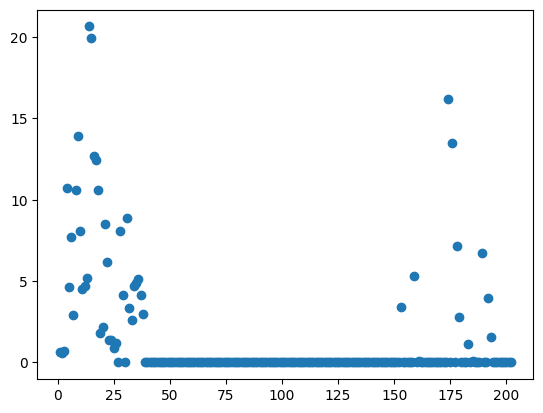

Indices of selected features: [13, 14, 173, 8, 175, 15, 16, 3, 17, 7, 30, 20]
Values of selected features: [20.63974, 19.92032, 16.20907, 13.91057, 13.49403, 12.68193, 12.41004, 10.74214, 10.62536, 10.57722, 8.899038, 8.477417]
stcpb
dtcpb
service_-
dload
service_dns
smeansz
dmeansz
sttl
trans_depth
sload
ct_ftp
djit


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [15]:
import heapq
import os
import re
import matplotlib.pyplot as plt
import numpy as np
# import tensorflow as tf
import tensorflow.compat.v1 as tf
from pandas import read_csv

tf.disable_v2_behavior()

def get_indices(num_select, num_feature, file_weights):
	"""
	This function is to select maximum k features according to their
	weights.

	Pram:
		num_select: An interger, the number of the selected features
		num_feature: An interger, the number of the original features
		file_weights: A txt file storing a numpy array. Each row of the
		              array is the weight for a feature
	Return:
		a list containing the indices of selected features
	"""

	x = np.arange(1, num_feature + 1)
	y = np.loadtxt(file_weights)
	indices = heapq.nlargest(num_select, range(len(y)), y.take)
	plt.scatter(x, y)
	plt.show()
	plt.savefig('weights_dis.eps', format = 'eps')
	# print(indices)

	largest_values = [y[i] for i in indices]
	print("Indices of selected features:", indices)
	print("Values of selected features:", largest_values)

	return indices


def read_data(examples):
    features = {"features": tf.FixedLenFeature([num_feature], tf.float32),
                "label_2": tf.FixedLenFeature([len_label], tf.float32),
                "label_10": tf.FixedLenFeature([len_label], tf.float32)}
    parsed_features = tf.parse_single_example(examples, features)
    return parsed_features['features'], parsed_features['label_2'], \
           parsed_features['label_10']


# get next batch of data and label
def next_batch(filename, num_examples):

    data = tf.data.TFRecordDataset(filename)
    data = data.map(read_data)
    data = data.batch(num_examples)
    iterator = data.make_one_shot_iterator()
    next_data, next_label_2, next_label_10 = iterator.get_next()
    return next_data, next_label_2, next_label_10


def make_tfrecords(dataset, file_to_save):
	[features, label_2, label_10] = dataset

	with tf.python_io.TFRecordWriter(file_to_save) as writer:
		for index in range(features.shape[0]):
			feature = {'features': tf.train.Feature(float_list = tf.train.FloatList(value = features[index, :])),
			           'label_2': tf.train.Feature(float_list = tf.train.FloatList(value = label_2[index, :])),
			           'label_10': tf.train.Feature(float_list = tf.train.FloatList(value = label_10[index, :]))}
			example = tf.train.Example(features = tf.train.Features(feature = feature))
			writer.write(example.SerializeToString())


def selection(data, indices):
	"""
	select the columns (indicating the features) according to the indices
	"""

	return data[:, indices]


def select_feature(file, num_examples, indices):
	"""
	The main function of feature selection.

	Params:
	  file: The .tfrecords file containing original data.tfrecords
	  num_examples: The number of examples in the file
	  indices: The indices of features to be selected

	Return:
	  None
	  In the function, a new .tfrecords file with tail of 'selected'
	  will be created in the same folder with the original data
	"""

	with tf.Session() as sess:
		data, label_2, label_10 = sess.run(next_batch(file, num_examples))

	data_select = selection(data, indices)

	file_name = file.split('\\')[-1]
	file_tail = len('.tfrecords')
	file_to_save = file_name[:-1*file_tail] + '_select_' + str(len(indices)) + '.tfrecords'


	make_tfrecords([data_select, label_2, label_10], file_to_save)


def show_feature_name(indices):
	"""
	The function to convert indices to feature names

	Params:
	  indices:the indices of the features
	Return:
	  None.
	  The name of features will be print
	"""

	#dirname = os.path.dirname(os.getcwd())
	#file = os.path.join(dirname, 'normalized/', '1_test.csv')
	file = os.path.join( '/content/drive/MyDrive/Colab Notebooks/UNSW-NB15 - CSV Files/normalized/', '1_test.csv')
	# file = os.path.join( 'normalized/', '1_test.csv')
	data = read_csv(file, index_col = 0)
	cols = data.columns

	for x in indices:
		print(cols[x])


if __name__ == '__main__':

	num_select = 12   #The number of selected features
	num_feature = 202
	len_label = 1
	file_weights = '/content/drive/MyDrive/Colab Notebooks/UNSW-NB15 - CSV Files/feature_select_AE/weights_new_3.5.txt'
	# file_weights = 'feature_select_AE/weights_new_3.5.txt'

	indices = get_indices(num_select, num_feature, file_weights)
	#print(indices)
	show_feature_name(indices)

	dirname = os.path.dirname(os.getcwd())
	# file_folder = os.path.join(dirname, '/content/', 'normalized/')
	file_folder = "/content/drive/MyDrive/Colab Notebooks/UNSW-NB15 - CSV Files/normalized/"

	file_train = file_folder + 'train_202.tfrecords'
	file_valid = file_folder + 'validation_202.tfrecords'
	num_examples_train = 1778030
	num_examples_validation = 254005

	file_test = file_folder + 'test_202.tfrecords'
	num_examples_test = 508012

	select_feature(file_train, num_examples_train, indices)
	select_feature(file_valid, num_examples_validation, indices)
	select_feature(file_test, num_examples_test, indices)

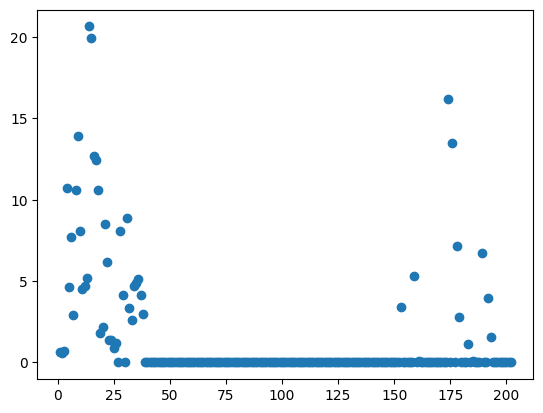

Indices of selected features: [13, 14, 173, 8, 175, 15, 16, 3, 17, 7, 30, 20]
Values of selected features: [20.63974, 19.92032, 16.20907, 13.91057, 13.49403, 12.68193, 12.41004, 10.74214, 10.62536, 10.57722, 8.899038, 8.477417]


[13, 14, 173, 8, 175, 15, 16, 3, 17, 7, 30, 20]

<Figure size 640x480 with 0 Axes>

In [16]:
get_indices(num_select, num_feature, file_weights)